In [1]:
# Konfigurasi Spark
import os
import sys

# 1. Mengeset variabel yang menyimpan lokasi di mana Spark diinstal
# spark_path = "D:/spark-2.1.0-bin-hadoop2.7"
spark_path = "D:/its/big_data/spark/"

# 2. Menentukan environment variable SPARK_HOME
os.environ['SPARK_HOME'] = spark_path

# 3. Simpan lokasi winutils.exe sebagai environment variable HADOOP_HOME
os.environ['HADOOP_HOME'] = spark_path

# 4. Lokasi Python yang dijalankan --> punya Anaconda
#    Apabila Python yang diinstall hanya Anaconda, maka tidak perlu menjalankan baris ini.
os.environ['PYSPARK_PYTHON'] = sys.executable

# 5. Konfigurasi path library PySpark
sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.10.4-src.zip")

# 6. Import library Spark
#    Dua library yang WAJIB di-import adalah **SparkContext** dan **SparkConf**.
from pyspark import SparkContext
from pyspark import SparkConf
import numpy as np

# Setting konfigurasi (opsional)
conf = SparkConf()
conf.set("spark.executor.memory", "2g")
conf.set("spark.cores.max", "4")

sc = SparkContext("local", conf=conf)
#    Apabila berhasil, maka ketika sc di-print akan mengeluarkan nilai <pyspark.context.SparkContext object>
print sc

In [2]:
from numpy import array

from pyspark.mllib.clustering import KMeans, KMeansModel

data = sc.textFile("complete.csv")

header = data.first()
data=data.filter(lambda line: line != header)

In [3]:
data.take(4)

[u'10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The Baptist Church sit,4/27/2004,29.8830556,-97.9411111,',
 u'10/10/1949 21:00,lackland afb,tx,,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX.  Lights racing across the sky &amp; making 90 degree turns on a dime.,12/16/2005,29.38421,-98.581082,',
 u'10/10/1955 17:00,chester (uk/england),,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 England,1/21/2008,53.2,-2.916667,',
 u'10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took a different route home,1/17/2004,28.9783333,-96.6458333,']

In [4]:
from collections import namedtuple
import matplotlib.pyplot as plt
from math import sqrt

def RepresentsFloat(s, r):
    try: 
        float(s)
        float(r)
        return True
    except ValueError:
        return False
fields = ('latitude','longitude')

Ufo = namedtuple('Ufo',fields,verbose=True)

def parse(row):
    row[9] = float(row[9])
    row[10]= float(row[10])
    return Ufo(*row[9:11])
    
temp_data = data.map(lambda x: x.split(','))
temp_data = temp_data.filter(lambda x: len(x) == 12)
temp_data = temp_data.filter(lambda x: RepresentsFloat(x[9],x[10]) == True)
datafix = temp_data.map(parse)

class Ufo(tuple):
    'Ufo(latitude, longitude)'

    __slots__ = ()

    _fields = ('latitude', 'longitude')

    def __new__(_cls, latitude, longitude):
        'Create new instance of Ufo(latitude, longitude)'
        return _tuple.__new__(_cls, (latitude, longitude))

    @classmethod
    def _make(cls, iterable, new=tuple.__new__, len=len):
        'Make a new Ufo object from a sequence or iterable'
        result = new(cls, iterable)
        if len(result) != 2:
            raise TypeError('Expected 2 arguments, got %d' % len(result))
        return result

    def __repr__(self):
        'Return a nicely formatted representation string'
        return 'Ufo(latitude=%r, longitude=%r)' % self

    def _asdict(self):
        'Return a new OrderedDict which maps field names to their values'
        return OrderedDict(zip(self._fields, self))

    def _replace(_self, **kwds):
        'Return a new Ufo object replacing specified fields with new values'
        result = _self._make(map

In [5]:
def plot(centers):
    for i in range(len(centers)):
        plt.plot(centers[i], '-o')
   
k=5     

parsedData = datafix.map(lambda line: array([line.latitude, line.longitude]))
clusters = KMeans.train(parsedData, k, maxIterations=1000, initializationMode="random")

<function matplotlib.pyplot.show>

C:\Users\exod\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


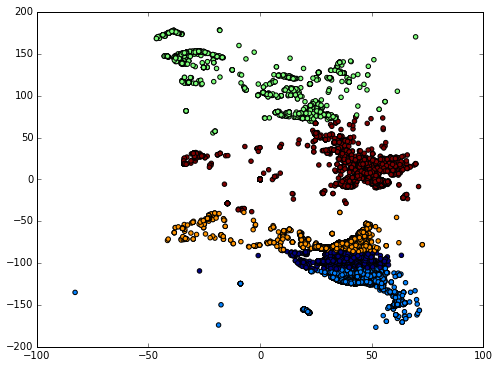

In [7]:
%matplotlib inline
cmap = plt.get_cmap('jet')
colormap = cmap(np.linspace(0, 1, k))

a=clusters.predict(parsedData)
b=parsedData.collect()        
c=np.mat(b)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(c[:,0], c[:,1], c=colormap[a.collect()], s=20)  
plt.show

In [8]:
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 797178.644179
